In [2]:
%load_ext autoreload
%autoreload 2


import argparse
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import glob

from dcase_models.model.container import *
from dcase_models.data.data_generator import DataGenerator
from dcase_models.data.features import MelSpectrogram
from dcase_models.data.datasets import UrbanSound8k
from dcase_models.util.files import load_json, mkdir_if_not_exists, save_pickle, load_pickle
from dcase_models.util.data import evaluation_setup

sys.path.append('../')
from apnet.model import *
from apnet.layers import PrototypeLayer, WeightedSum

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dataset_name = 'UrbanSound8k'
model_name = 'APNet'
features_name = 'MelSpectrogram'
fold_name = 'fold10'

In [4]:
# Get parameters
exp_path = '../experiments'
model_folder = os.path.join(exp_path, dataset_name, model_name)
parameters_file = os.path.join(model_folder, 'config.json')
params = load_json(parameters_file)
params_dataset = params['datasets'][dataset_name]
params_features = params['features'][features_name]
params_model = params['models']['APNet']

In [5]:
dataset_path = os.path.join(exp_path, params_dataset['dataset_path'])
dataset = UrbanSound8k(dataset_path)
dataset.check_if_downloaded()

True

In [6]:
features = MelSpectrogram(**params_features)
features.check_if_extracted(dataset)

True

In [7]:
exp_folder = os.path.join(model_folder, fold_name)
scaler = load_pickle(os.path.join(exp_folder, 'scaler.pickle'))

model_container = APNet(
    model=None, model_path=exp_folder, 
    custom_objects={
        'PrototypeLayer': PrototypeLayer,
        'WeightedSum': WeightedSum,
    },
    metrics=['classification'],
    **params['models']['APNet']['model_arguments']
)
model_container.load_model_weights(exp_folder)
model_container.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 84, 128)      0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 21, 32, 32), 52096       input[0][0]                      
__________________________________________________________________________________________________
features (Lambda)               (None, 21, 32, 32)   0           encoder[1][0]                    
__________________________________________________________________________________________________
prototype_distances (PrototypeL (None, 50, 32)       1075200     features[0][0]                   
__________________________________________________________________________________________________
similarity

In [8]:
folds_train, folds_val, _ = evaluation_setup(
    fold_name, dataset.fold_list,
    params_dataset['evaluation_mode'],
    use_validate_set=True
)
data_gen = DataGenerator(
    dataset, features, folds=folds_val,
    batch_size=params['train']['batch_size'],
    shuffle=False, train=True, scaler=scaler
)
data_gen_train = DataGenerator(
    dataset, features, folds=folds_train,
    batch_size=params['train']['batch_size'],
    shuffle=False, train=True, scaler=scaler
)

In [9]:
X, Y = data_gen.get_data()
print(X.shape, Y.shape)
X_train, Y_train = data_gen_train.get_data()
print(X_train.shape, Y_train.shape)

(873, 84, 128) (873, 10)
(7022, 84, 128) (7022, 10)


In [10]:
model_container.get_prototypes(X_train)
model_container.update_model_to_prototypes()

Getting prototypes (spectrograms)...
Done!
Converting to audio...
Done!


In [11]:
model_similarity = model_container.model_input_to_distances()

ws_similarity = model_similarity.predict(X)
print(ws_similarity.shape)

(873, 50)


In [12]:
weights = model_similarity.get_layer('mean').get_weights()[0]

new_weights = np.ones(weights.shape)*1/float(weights.shape[1])
print(new_weights)

[[0.03125 0.03125 0.03125 ... 0.03125 0.03125 0.03125]
 [0.03125 0.03125 0.03125 ... 0.03125 0.03125 0.03125]
 [0.03125 0.03125 0.03125 ... 0.03125 0.03125 0.03125]
 ...
 [0.03125 0.03125 0.03125 ... 0.03125 0.03125 0.03125]
 [0.03125 0.03125 0.03125 ... 0.03125 0.03125 0.03125]
 [0.03125 0.03125 0.03125 ... 0.03125 0.03125 0.03125]]


In [13]:
model_similarity.get_layer('mean').set_weights([new_weights])

In [14]:
mean_similarity = model_similarity.predict(X)
print(mean_similarity.shape)

(873, 50)


In [15]:
ann = np.argmax(Y, axis=1)

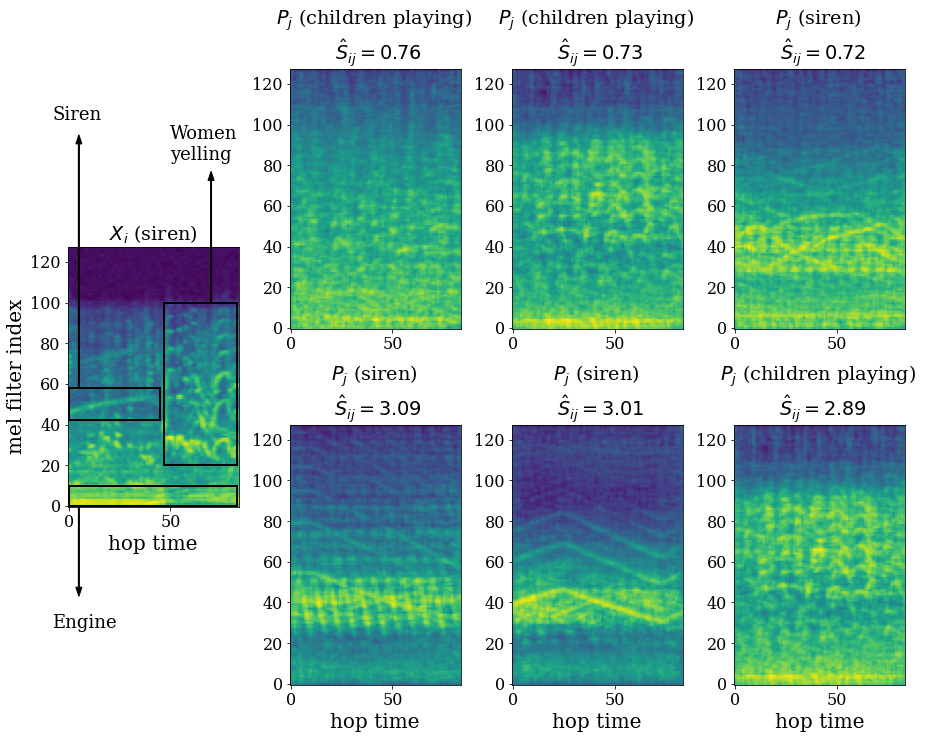

In [17]:
import matplotlib.patches as patches

j = 105 #150 es buen ejemplo


plt.rcParams.update({'font.size': 16, 'font.family': 'serif'})

class_names = (['air conditioner', 'car horn', 'children playing',
           'dog bark', 'drilling', 'engine idling', 'gun shot',
           'jackhammer', 'siren', 'street music'])  

argsort_ws = np.argsort(ws_similarity[j])
argsort_mean = np.argsort(mean_similarity[j])

fig = plt.figure(figsize=(15,12), constrained_layout=False)
N_protos = 3
gs = fig.add_gridspec(nrows=2, ncols=N_protos+1, wspace=0.3)
ax0 = fig.add_subplot(gs[0:2, 0])
ax = {0: {}, 1: {}}
for k in range(1, N_protos+1):
    ax[0][k] = fig.add_subplot(gs[0, k])
    ax[1][k] = fig.add_subplot(gs[1, k])

#plt.subplot(2, 3, 1)
ax0.imshow(X[j].T, origin='lower')
ax0.set_title('$X_i$ (' + dataset.label_list[ann[j]] + ')' )
ax0.set_xlabel('hop time', fontsize=20)
ax0.set_ylabel('mel filter index', fontsize=20)

# Create a Rectangle patch
rect = patches.Rectangle((0, 42), 45, 16, linewidth=2, edgecolor='k', facecolor='none')
ax0.add_patch(rect)

rect = patches.Rectangle((0, 0), 83, 10, linewidth=2, edgecolor='k', facecolor='none')
ax0.add_patch(rect)

rect = patches.Rectangle((47, 20), 36, 80, linewidth=2, edgecolor='k', facecolor='none')
ax0.add_patch(rect)

ax0.arrow(5, 0, 0, -40, clip_on=False, width=0.5, head_width=3, color='k')
ax0.text(-8, -60, 'Engine', fontsize=18)


ax0.arrow(5, 58, 0, 120, clip_on=False, width=0.5, head_width=3, color='k')
ax0.text(-8, 190, 'Siren', fontsize=18)

ax0.arrow(70, 100, 0, 60, clip_on=False, width=0.5, head_width=3, color='k')
ax0.text(50, 170, 'Women\nyelling', fontsize=18)

#plt.subplot(2, 3, 2):
for k in range(1, N_protos+1):
    ax[0][k].imshow(model_container.prototypes.mel_spectrograms[argsort_mean[-k]].T, origin='lower')
    class_name = class_names[model_container.prototypes.classes[argsort_mean[-k]]]
    ax[0][k].set_title('$P_{j}$ (%s) \n $\hat{S}_{ij}=%0.2f$' % (class_name, mean_similarity[j, argsort_mean[-k]]))
    #ax[0][k].set_xticks([])
    
    ax[1][k].imshow(model_container.prototypes.mel_spectrograms[argsort_ws[-k]].T, origin='lower')
    class_name = class_names[model_container.prototypes.classes[argsort_ws[-k]]]
    ax[1][k].set_title('$P_{j}$ (%s) \n $\hat{S}_{ij}=%0.2f$' % (class_name, ws_similarity[j, argsort_ws[-k]]))
    ax[1][k].set_xlabel('hop time', fontsize=20)
    
    #if k == 1:
    #    ax[0][k].set_ylabel('mel filter index', fontsize=18)
    #    ax[1][k].set_ylabel('mel filter index', fontsize=18)
    
#plt.subplot(2, 3, 3)
#plt.imshow(model_container.prototypes.mel_spectrograms[argsort_mean[-2]].T, origin='lower')

#plt.subplot(2, 3, 4)
#plt.imshow(X[j].T, origin='lower')
#plt.subplot(2, 3, 5)
#plt.imshow(model_container.prototypes.mel_spectrograms[argsort_ws[-1]].T, origin='lower')
#plt.subplot(2, 3, 6)
#plt.imshow(model_container.prototypes.mel_spectrograms[argsort_ws[-2]].T, origin='lower')
plt.savefig('images/test_weighted_sum.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()
